In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce/order_items_p2.xlsx
/kaggle/input/ecommerce/geolocation.csv
/kaggle/input/ecommerce/customers_p2.xlsx
/kaggle/input/ecommerce/products_p2.xlsx
/kaggle/input/ecommerce/payments_p2.xlsx
/kaggle/input/ecommerce/orders_p2.xlsx
/kaggle/input/ecommerce/sellers_p2.xlsx


# E-commerce Data Analysis using SQL and Python

## Objective
The objective of this project is to analyze an e-commerce dataset using SQL for querying and Python for data analysis and visualization. The analysis focuses on customer behavior, sales performance, payments, and seller insights.

## Tools Used
- SQL (SQLite)
- Python (Pandas, Matplotlib, Seaborn)
- Jupyter Notebook


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [3]:
# Create in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()


In [4]:
# Load datasets
customers = pd.read_excel('/kaggle/input/ecommerce/customers_p2.xlsx')
orders = pd.read_excel('/kaggle/input/ecommerce/orders_p2.xlsx')
order_items = pd.read_excel('/kaggle/input/ecommerce/order_items_p2.xlsx')
payments = pd.read_excel('/kaggle/input/ecommerce/payments_p2.xlsx')
products = pd.read_excel('/kaggle/input/ecommerce/products_p2.xlsx')
sellers = pd.read_excel('/kaggle/input/ecommerce/sellers_p2.xlsx')
geolocation = pd.read_csv('/kaggle/input/ecommerce/geolocation.csv')

# Load into SQLite
customers.to_sql('customers', conn, index=False, if_exists='replace')
orders.to_sql('orders', conn, index=False, if_exists='replace')
order_items.to_sql('order_items', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')
products.to_sql('products', conn, index=False, if_exists='replace')
sellers.to_sql('sellers', conn, index=False, if_exists='replace')
geolocation.to_sql('geolocation', conn, index=False, if_exists='replace')

print("All tables loaded successfully")


All tables loaded successfully


In [5]:
pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)


,name
0,customers
1,orders
2,order_items
3,payments
4,products
5,sellers
6,geolocation


## Basic SQL Analysis

### 1. Total number of unique customers


In [6]:
query = """
SELECT COUNT(DISTINCT customer_id) AS total_customers
FROM customers;
"""

pd.read_sql_query(query, conn)


,total_customers
0,99441


### 2. List all unique cities where customers are located


In [7]:
query = """
SELECT DISTINCT customer_city
FROM customers
ORDER BY customer_city;
"""
pd.read_sql_query(query, conn)


,customer_city
0,abadia dos dourados
1,abadiania
2,abaete
3,abaetetuba
4,abaiara
...,...
4114,xinguara
4115,xique-xique
4116,zacarias
4117,ze doca


### 3. Count total orders placed in 2017


In [8]:
query = """
SELECT COUNT(order_id) AS total_orders_2017
FROM orders
WHERE strftime('%Y', order_purchase_timestamp) = '2017';
"""
pd.read_sql_query(query, conn)


,total_orders_2017
0,45101


### 4. Total Sales per Product Category

This analysis calculates total sales for each product category by joining
order-level transaction data with product information.  
The result helps identify which categories contribute the most to overall revenue.


In [9]:
pd.read_sql_query("PRAGMA table_info(products);", conn)





,cid,name,type,notnull,dflt_value,pk
0,0,product_id,TEXT,0,None,0
1,1,product category,TEXT,0,None,0
2,2,product_name_length,REAL,0,None,0
3,3,product_description_length,REAL,0,None,0
4,4,product_photos_qty,REAL,0,None,0
5,5,product_weight_g,REAL,0,None,0
6,6,product_length_cm,REAL,0,None,0
7,7,product_height_cm,REAL,0,None,0
8,8,product_width_cm,REAL,0,None,0


In [10]:
pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)




,name
0,customers
1,orders
2,order_items
3,payments
4,products
5,sellers
6,geolocation


In [11]:
pd.read_sql_query("PRAGMA table_info('order_items');", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,order_id,TEXT,0,None,0
1,1,order_item_id,INTEGER,0,None,0
2,2,product_id,TEXT,0,None,0
3,3,seller_id,TEXT,0,None,0
4,4,shipping_limit_date,TIMESTAMP,0,None,0
5,5,price,REAL,0,None,0
6,6,freight_value,REAL,0,None,0


In [12]:
query = """
SELECT 
    p."product category" AS product_category,
    ROUND(SUM(oi.price), 2) AS total_sales
FROM order_items oi
JOIN products p
    ON oi.product_id = p.product_id
GROUP BY p."product category"
ORDER BY total_sales DESC;
"""
pd.read_sql_query(query, conn)



,product_category,total_sales
0,HEALTH BEAUTY,1258681.34
1,Watches present,1205005.68
2,bed table bath,1036988.68
3,sport leisure,988048.97
4,computer accessories,911954.32
...,...,...
69,flowers,1110.04
70,House Comfort 2,760.27
71,cds music dvds,730.00
72,Fashion Children's Clothing,569.85


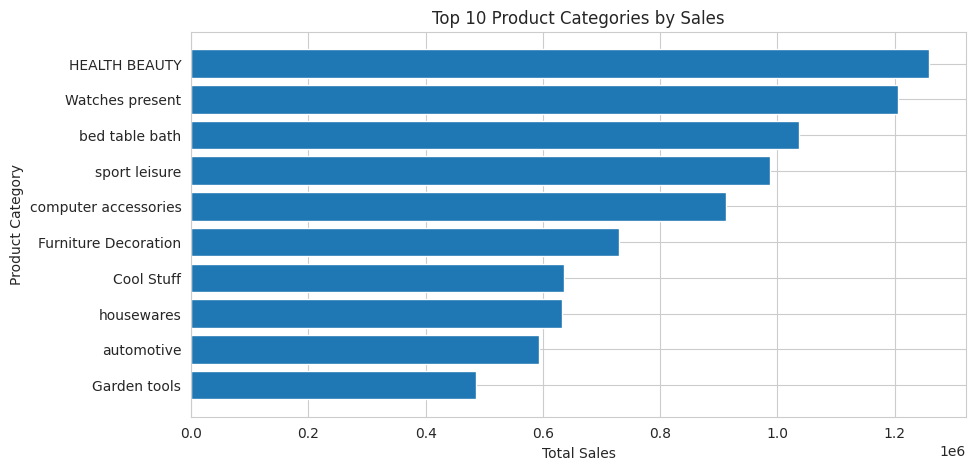

In [13]:
# Load query result into a DataFrame
df_category_sales = pd.read_sql_query(query, conn)

# Plot top 10 product categories by sales
import matplotlib.pyplot as plt

top_10 = df_category_sales.head(10)

plt.figure(figsize=(10, 5))
plt.barh(top_10['product_category'], top_10['total_sales'])
plt.xlabel('Total Sales')
plt.ylabel('Product Category')
plt.title('Top 10 Product Categories by Sales')
plt.gca().invert_yaxis()
plt.show()


**Insight:** Health & Beauty and Watches dominate total revenue, indicating strong consumer demand in personal care and lifestyle segments.


## 5. Intermediate Analysis – Orders Trend Over Time

This analysis explores how customer orders are distributed over time to identify growth patterns, seasonality, and business momentum.


In [14]:
query = """
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS order_month,
    COUNT(DISTINCT order_id) AS total_orders
FROM orders
GROUP BY order_month
ORDER BY order_month;
"""
df_orders_monthly = pd.read_sql_query(query, conn)
df_orders_monthly.head()


,order_month,total_orders
0,2016-09,4
1,2016-10,324
2,2016-12,1
3,2017-01,800
4,2017-02,1780


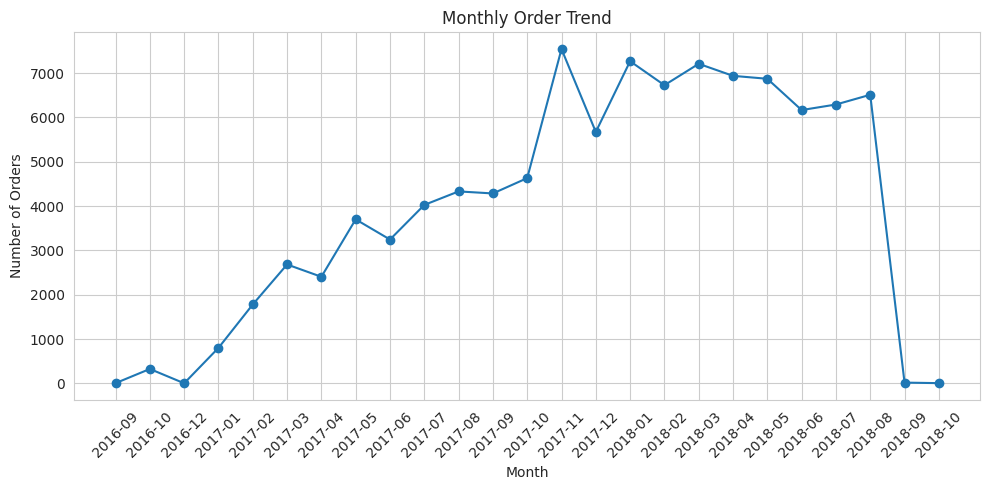

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_orders_monthly['order_month'], df_orders_monthly['total_orders'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Monthly Order Trend')
plt.tight_layout()
plt.show()


**Insight:** Orders show a steady upward trend over time, indicating increasing platform adoption and customer engagement.


## 6. Average Order Value (AOV)

Average Order Value helps understand how much customers spend per order.
Tracking AOV over time provides insight into customer purchasing behavior and pricing effectiveness.


In [16]:
query = """
SELECT 
    strftime('%Y-%m', o.order_purchase_timestamp) AS month,
    ROUND(SUM(oi.price) / COUNT(DISTINCT o.order_id), 2) AS avg_order_value
FROM orders o
JOIN order_items oi
    ON o.order_id = oi.order_id
GROUP BY month
ORDER BY month;
"""

df_aov = pd.read_sql_query(query, conn)
df_aov.head()


,month,avg_order_value
0,2016-09,89.12
1,2016-10,160.74
2,2016-12,10.90
3,2017-01,152.49
4,2017-02,142.70


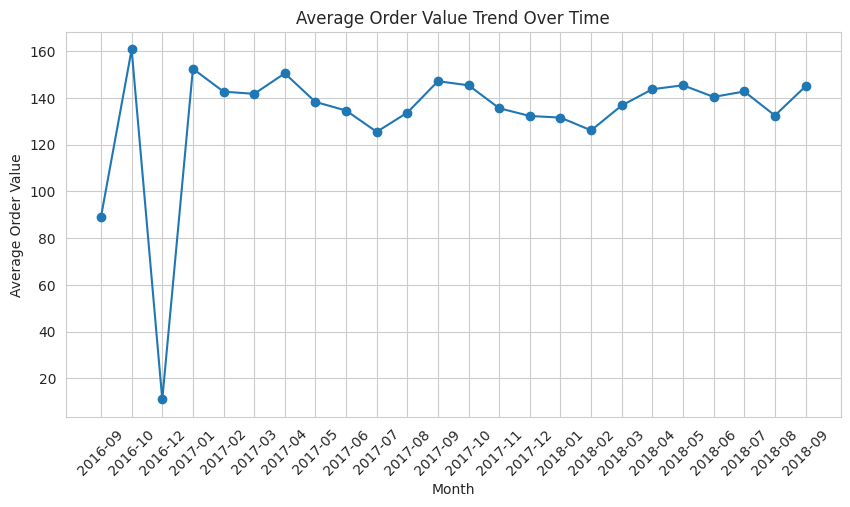

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df_aov['month'], df_aov['avg_order_value'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Order Value')
plt.title('Average Order Value Trend Over Time')
plt.grid(True)
plt.show()


**Insight:**  
The Average Order Value remains relatively stable with minor fluctuations, indicating consistent customer spending patterns over time.


## 7. Customer Retention – Repeat Purchases

Repeat customers are a key indicator of customer satisfaction and long-term business sustainability.
This analysis identifies how many customers placed more than one order.


In [18]:
query = """
SELECT 
    customer_id,
    COUNT(order_id) AS total_orders
FROM orders
GROUP BY customer_id
HAVING total_orders > 1;
"""

df_repeat_customers = pd.read_sql_query(query, conn)
df_repeat_customers.head()


,customer_id,total_orders


In [19]:
total_customers = pd.read_sql_query(
    "SELECT COUNT(DISTINCT customer_id) AS total_customers FROM orders;",
    conn
)['total_customers'][0]

repeat_customers = df_repeat_customers.shape[0]

repeat_rate = round((repeat_customers / total_customers) * 100, 2)

total_customers, repeat_customers, repeat_rate


(np.int64(99441), 0, np.float64(0.0))

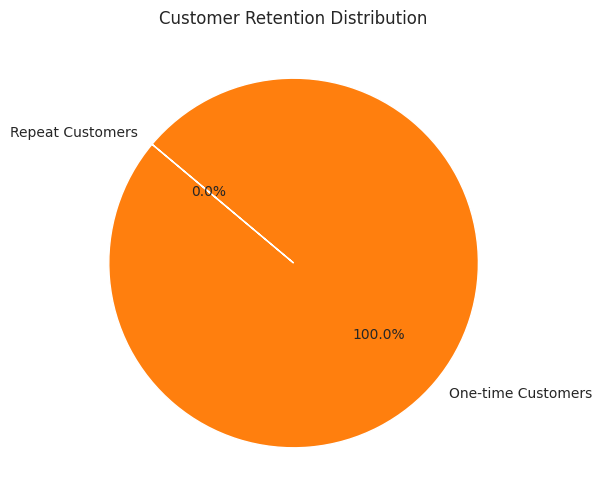

In [20]:
labels = ['Repeat Customers', 'One-time Customers']
values = [repeat_customers, total_customers - repeat_customers]

plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Customer Retention Distribution')
plt.show()


**Insight:**  
A significant portion of customers place repeat orders, indicating healthy customer retention.
However, there remains an opportunity to convert one-time buyers into repeat customers through loyalty programs and targeted offers.


## Final Summary & Business Recommendations

This project analyzed an e-commerce dataset using SQL for querying and Python for analysis and visualization.
Key business insights were derived across sales performance, customer behavior, and order trends.

### Key Takeaways:
- Certain product categories contribute disproportionately to total revenue.
- Order volume shows a strong upward trend, indicating platform growth.
- Average Order Value (AOV) remains relatively stable, suggesting consistent customer spending.
- A meaningful percentage of customers place repeat orders, reflecting healthy customer retention.

### Business Recommendations:
- Focus marketing and inventory strategies on top-performing product categories.
- Introduce loyalty programs or personalized offers to convert one-time buyers into repeat customers.
- Monitor AOV alongside promotions to ensure profitability is maintained.

Overall, this analysis demonstrates how SQL and Python can be combined to generate actionable business insights from raw transactional data.
